<table class="ee-notebook-buttons" align="left">
    <td><a target="_blank"  href="https://github.com/NINAnor/urban-treeDetection"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" style="filter: invert(100%)"/> View source on GitHub</a></td>
    <td><a target="_blank"  href="https://drive.google.com/drive/folders/1mEQBfa-tVViVWFt27XzUP4Wr19u1iuZm"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a></td>
</table>

# Urban Tree Detection | Extrapolating Ecosystem Service Values

**Author:** Willeke A'Campo

**Description:** Script to clean the output i-Tree Eco dataset and extrapolate the Ecosystem Service Values to all trees in the municipality. The regression is trained on the in situ tree dataset from the municipality or if not availabe on Oslo's tree in situ tree data. 

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import geopandas as gpd
from scipy import stats
#from splot.esda import moran_scatterplot, plot_moran

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
# import  py-packages 
import os
import logging 

# import local packages
from src import (MUNICIPALITY, TOOL_PATH, DATA_PATH, INTERIM_PATH)
from src import logger

In [10]:
print(INTERIM_PATH)

C:\Data\offline_data\trekroner\data\oslo\interim


In [11]:
# configure logger
logger.setup_logger(logfile=False)
logging.info(f'Start preparing the tree database of {MUNICIPALITY}.')

# print global project variables
print(f'data_path: {DATA_PATH}')
print(f'interim_data_path: {INTERIM_PATH}')

2023.05.26T15:14:07Z [DEBUG] src.utils.logger: Logging initialized
2023.05.26T15:14:07Z [INFO] root: Start preparing the tree database of oslo.
data_path: C:\Data\offline_data\trekroner\data
interim_data_path: C:\Data\offline_data\trekroner\data\oslo\interim


### Import Reference Data Oslo

In [12]:
# load the Excel file into a lookup dictionairy 
excel_path = os.path.join(INTERIM_PATH, "oslo_reference_data.xlsx")
print(excel_path)

workbook = pd.ExcelFile(excel_path)
sheet_names = workbook.sheet_names
print(f"workbook sheet names: {sheet_names}")

# import Oslo's reference dataset
df_raw = pd.read_excel(excel_path, sheet_name="oslo_reference_data")

# import metadata
df_metadata = pd.read_excel(excel_path, sheet_name="metadata")
df_metadata = df_metadata[['urban-treeDetection_colnames', 'python_colnames', 'dtype']]

# import genus list 
df_genus = pd.read_excel(excel_path, sheet_name="unique_genus")
genus_bins = df_genus['genus'].tolist()

print("Raw data information: Oslo Reference Data")
display(df_raw.head())
print("Rows in dataframe: ", len(df_raw))
print(f"\nunique genus: {genus_bins}")
print("\nMetadata information: ")
display(df_metadata.head())

C:\Data\offline_data\trekroner\data\oslo\interim\oslo_reference_data.xlsx
workbook sheet names: ['test_extrapolation_data', 'oslo_reference_data', 'unique_taxon', 'unique_genus', 'metadata']
Raw data information: Oslo Reference Data


,tree_id,crown_id,pollution_zone,crown_area_m2,tree_height_m,taxon_name,dbh_cm,crown_area_origin,total_tree_height_origin,taxon_origin,...,co_seq_kg,runoff_m3,polution_no2_g,polution_so2_g,polution_pm25_g,polution_co_g,polution_o3_g,totben_cap_nok,wgs84_lon,wgs84_lat
0,14689,4977.0,1.0,87.319154,15.081635,NaN,37.386005,"ALS, intersecting BYM, LiDAR",measured from DSM-DTM 3x3 rook's nb,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.657796,59.969877
1,14690,4978.0,1.0,105.000534,4.408203,NaN,13.635651,"ALS, intersecting BYM, LiDAR",measured from DSM-DTM point value,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.657938,59.969788
2,14691,NaN,1.0,NaN,1.832062,NaN,6.637312,NaN,measured from DSM-DTM 3x3 rook's nb,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.658075,59.969748
3,14692,NaN,1.0,NaN,3.208923,NaN,10.509838,NaN,measured from DSM-DTM 3x3 rook's nb,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.658295,59.969679
4,14693,17997.0,1.0,9.230826,0.679657,NaN,2.943466,"ALS, intersecting BYM, Thiessen",measured from DSM-DTM 3x3 rook's nb,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.657486,59.970029


Rows in dataframe:  29928

unique genus: ['Fraxinus', 'Acer', 'Ulmus', 'Betula', 'Picea', 'Pinus', 'Fagus', 'Tilia', 'Thuja', 'Salix', 'Populus', 'Alnus', 'Quercus', 'Malus', 'Prunus', 'Aesculus', 'Larix', 'Laburnum', 'Sorbus', 'Photinia', 'Cercidiphyllum', 'Pseudotsuga', 'Carpinus', 'Cupressocyparis', 'Juglans', 'Magnolia', 'Pyrus', 'Ginkgo', 'Crataegus', 'Syringa', 'Abies', 'Tsuga', 'Corylus', 'Pterocarya', 'Castanea', 'Metasequoia', 'Taxus', 'Liriodendron', 'Phellodendron', 'Ailanthus', 'Robinia', 'Davidia', 'Platanus', 'Juniperus']

Metadata information: 


,urban-treeDetection_colnames,python_colnames,dtype
0,tree_id,tree_id,int
1,crown_id,crown_id,int
2,pollution_zone,pollution_zone,int
3,crown_area_m2,crown_area,float64
4,tree_height_m,tree_height,float64


### Clean dataset
- remove rows with missing values
- remove rows with negative values (not done)

In [13]:
# drop rows with missing values
df = df_raw.dropna()
# drop rows with missing values
df = df.dropna()
display(df.head())

,tree_id,crown_id,pollution_zone,crown_area_m2,tree_height_m,taxon_name,dbh_cm,crown_area_origin,total_tree_height_origin,taxon_origin,...,co_seq_kg,runoff_m3,polution_no2_g,polution_so2_g,polution_pm25_g,polution_co_g,polution_o3_g,totben_cap_nok,wgs84_lon,wgs84_lat
73,14640,18010.0,1.0,7.644361,6.354904,Fraxinus,18.404785,"ALS, intersecting BYM, Thiessen",measured from DSM-DTM 3x3 rook's nb,1.0,...,3.0,0.1,8.2,0.6,0.9,0.7,18.3,671.685832,10.641744,59.961983
75,14644,4988.0,1.0,168.883335,15.855560,Acer,38.952046,"ALS, intersecting BYM, LiDAR",measured from DSM-DTM 3x3 rook's nb,1.0,...,15.1,3.7,234.5,17.3,24.5,21.2,525.4,15053.486424,10.642142,59.962042
76,14645,18012.0,1.0,126.770866,18.937744,Fraxinus,45.059931,"ALS, intersecting BYM, Thiessen",measured from DSM-DTM 3x3 rook's nb,1.0,...,10.6,1.6,99.3,7.3,10.4,9.0,222.4,7341.197038,10.642501,59.962011
78,14647,4987.0,1.0,221.395426,16.470413,Fraxinus,40.186395,"ALS, intersecting BYM, LiDAR",measured from DSM-DTM point value,1.0,...,12.9,2.1,132.5,9.8,13.8,12.0,296.9,9792.374558,10.643127,59.962118
79,14648,4985.0,1.0,124.750169,12.257553,Ulmus,31.540783,"ALS, intersecting BYM, LiDAR",measured from DSM-DTM 3x3 rook's nb,1.0,...,9.5,1.5,96.5,7.1,10.1,8.7,216.1,6663.597074,10.643412,59.962164


- rename columns 
- trim column names
- set dtype of columns 

In [14]:
# trim and rename columns using metadata 
col_name_mapping = dict(zip(df_metadata['urban-treeDetection_colnames'], df_metadata['python_colnames']))
df.columns = df.columns.str.strip()
df.rename(columns=col_name_mapping, inplace=True)
df.columns = df.columns.str.strip()

# update column dtypes using metadata
dtype_mapping = dict(zip(df_metadata['python_colnames'], df_metadata['dtype']))

# remove all values from dtype_mapping if they are not in df.columns
dtype_mapping = {key: dtype_mapping[key] for key in dtype_mapping.keys() if key in df.columns}

# convert column dtypes using dtype_mapping
for key in dtype_mapping.keys():
    #print(f"column: {key}\t current dtype: {df[key].dtypes} \ttarget dtype: {dtype_mapping[key]}")
    # if the current dtype is not the target dtype, convert the column
    if df[key].dtypes != dtype_mapping[key]:
        try:
            if dtype_mapping[key] == 'int':
                df[key] = df[key].astype(int)
                print(f"column: {key} converted to {df[key].dtypes}")
            elif dtype_mapping[key] == 'float64':
                df[key] = df[key].astype(float)
                print(f"column: {key} converted to {df[key].dtypes}")
            elif dtype_mapping[key] == 'object':
                df.astype({key: 'object'}).dtypes
                print(f"column: {key} converted to {df[key].dtypes}")
        except ValueError:
            print(f"column: {key} ({df[key].dtypes}) could not be converted to {dtype_mapping[key]}")
            pass
    else: 
        print(f"column: {key} ({df[key].dtypes}) has already dtype: {dtype_mapping[key]}")
        pass

column: tree_id converted to int32
column: crown_id converted to int32
column: pollution_zone converted to int32
column: crown_area (float64) has already dtype: float64
column: tree_height (float64) has already dtype: float64
column: genus (object) has already dtype: object
column: dbh (float64) has already dtype: float64
column: crown_area_origin (object) has already dtype: object
column: height_origin (object) has already dtype: object
column: sp_in_situ converted to int32
column: dbh_in_situ converted to int32
column: dbh_origin (object) has already dtype: object
column: carbon_storage (float64) has already dtype: float64
column: carbon_seq (float64) has already dtype: float64
column: runoff (float64) has already dtype: float64
column: polution_no2 (float64) has already dtype: float64
column: polution_so2 (float64) has already dtype: float64
column: polution_pm25 (float64) has already dtype: float64
column: polution_co (float64) has already dtype: float64
column: polution_o3 (float6

2023.05.26T15:14:12Z [DEBUG] matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023.05.26T15:14:12Z [DEBUG] matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023.05.26T15:14:12Z [DEBUG] matplotlib.font_manager: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2023.05.26T15:14:12Z [DEBUG] matplotlib.font_manager: findfont: score(FontEntry(fname='c:\\Users\\willeke.acampo\\Anaconda3\\envs\\urban-treeDetection\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023.05.26T15:14:12Z [DEBUG] matplotlib.font_manager: findfont: score(FontEntry(fname='c:\\Users\\willeke.acampo\\Anaconda3\\envs\\urban-treeDetection\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='no

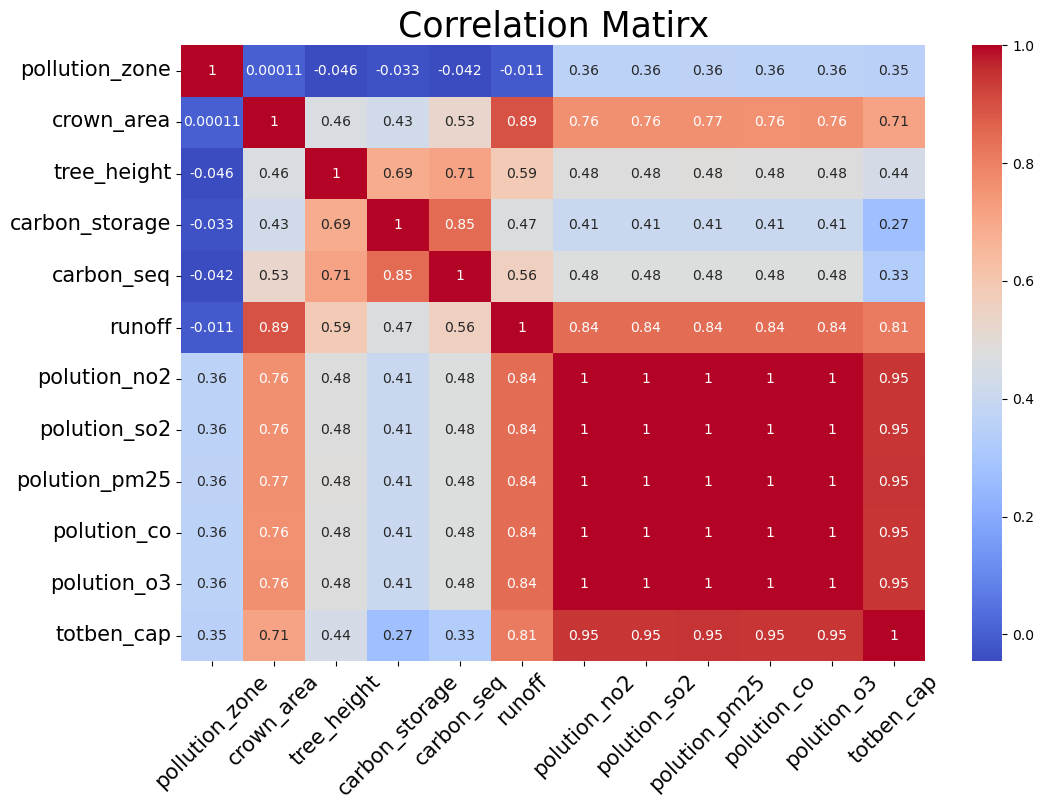

In [15]:
# Perform correlation analysis
# drop columns with name 'id' and 'genus'
df_corr = df.drop(['tree_id', 'crown_id','dbh','dbh_in_situ','sp_in_situ','lon_x', 'lat_y'], axis=1)
correlation_matrix = df_corr.corr()

fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
ax.set_title("Correlation Matirx", fontweight='ultralight', fontsize=25)
plt.xticks(rotation=45,fontweight='ultralight', fontsize=15)
plt.yticks(fontsize=15)
plt.show()

- select columns to keep for modelling
- round values for pred and response var to 3 decimals (ensure that X,Y columns are not rounded!)

In [16]:
#print(df.columns)
col_id = ['tree_id']
col_response = ['runoff']
col_predictors = ['pollution_zone', 'crown_area', 'tree_height', 'genus', 'dbh']
col_coord = ['lon_x', 'lat_y']

col_to_keep = col_id + col_response + col_predictors + col_coord
print(col_to_keep)
df = df[col_to_keep]

# round response and predictor values to 2 decimals
df[col_response + col_predictors] = df[col_response + col_predictors].round(2)
display(df.head())

['tree_id', 'runoff', 'pollution_zone', 'crown_area', 'tree_height', 'genus', 'dbh', 'lon_x', 'lat_y']


,tree_id,runoff,pollution_zone,crown_area,tree_height,genus,dbh,lon_x,lat_y
73,14640,0.1,1,7.64,6.35,Fraxinus,18.40,10.641744,59.961983
75,14644,3.7,1,168.88,15.86,Acer,38.95,10.642142,59.962042
76,14645,1.6,1,126.77,18.94,Fraxinus,45.06,10.642501,59.962011
78,14647,2.1,1,221.40,16.47,Fraxinus,40.19,10.643127,59.962118
79,14648,1.5,1,124.75,12.26,Ulmus,31.54,10.643412,59.962164


### Data distribution


In [ ]:
# Specify the states for 'crown_area', 'tree_height', and 'pollution_zone'
states_pz = [1, 2, 3]
len_states_pz = len(states_pz)
states_ca = list(range(0, 375, 25))+[float('inf')]
len_states_ca = len(states_ca)-1
states_th = list(range(0, 40, 5))+[float('inf')]
len_states_th = len(states_th)-1
states_co = [-float('inf'), 21, 48, 58, 97,185, 378, 664, 991, 1397, 1625, float('inf')]
len_states_co = len(states_co)-1

print("pollution_zone_states:\t", states_pz, "count:", len_states_pz)
print("crown_area_states:\t", states_ca, "count:", len_states_ca)
print("tree_height_states:\t", states_th, "count:", len_states_th)
print("carbon_states:\t\t", states_co, "count:", len_states_co)

# create bin_labels form states
bin_labels_pz = [f"pz_{i+1}" for i in range(len_states_pz)]
# create labels like this 0-25, 25-50 ... 350-inf for crown area
bin_labels_ca = [f"{i}-{i+25}" for i in range(0, 350, 25)]+[f"{350}-inf"]
bin_labels_th = [f"{i}-{i+5}" for i in range(0, 35, 5)]+[f"{35}-inf"]
bin_labels_co = [f"{states_co[i]}-{states_co[i+1]}" for i in range(len_states_co)]

# print bin labels
print("pollution_zone_bin_labels:\t", bin_labels_pz)
print("crown_area_bin_labels:\t\t", bin_labels_ca)
print("tree_height_bin_labels:\t\t", bin_labels_th)
print("carbon_bin_labels:\t\t", bin_labels_co)


In [ ]:
# create a new column for each state
df['crown_area_bins'] = pd.cut(df['crown_area'], bins=states_ca, labels=bin_labels_ca, include_lowest=True)
df['tree_height_bins'] = pd.cut(df['tree_height'], bins=states_th, labels=bin_labels_th, include_lowest=True)  
#df['carbon_storage_bins'] = pd.cut(df['carbon_storage'], bins=states_co, labels=bin_labels_co, include_lowest=True)
display(df.head())

In [ ]:
sns.set_theme(context="notebook",   # paper, notebook, talk, and poster
              style="white",     # darkgrid, whitegrid, dark, white, and ticks
              palette="deep",       # deep, muted, bright, pastel, dark, and colorblind
              font="sans-serif",    # font family: serif, sans-serif, cursive, fantasy, and monospace, Open Sans
              font_scale=1,         # 1 = default font size (12pt)
              color_codes=True,     # False = don't color code from current palette
              rc=None               # dict for additional settings (e.g. axes.labelsize=15)
              )

In [ ]:
# create a histogram for genus distribution
df_genus = df.groupby('genus').count()
df_genus = df_genus[['tree_id']]
df_genus.rename(columns={'tree_id': 'count'}, inplace=True)
df_genus.sort_values(by=['count'], inplace=True, ascending=False)
df_genus.reset_index(inplace=True)

# probability distribution of genus in percent
df_genus['probability'] = df_genus['count']/df_genus['count'].sum()
df_genus['prob_percentage'] = round(df_genus['probability']*100)
display(df_genus.head())

df_genus['probability'].sum()

In [ ]:
len(df)

In [ ]:
# plot histogram
fig, ax = plt.subplots(figsize=(30, 5))
sns.barplot(x='genus', y='prob_percentage', data=df_genus, ax=ax, color="darkgreen")
ax.set_title("Tree Genus Probability Distribution in Oslo", fontweight='ultralight', fontsize=20)
ax.set_xlabel("Genus", fontweight='bold')
ax.set_ylabel("Probability (%)", fontweight='bold')
plt.xticks(rotation=45,fontweight='ultralight') 
plt.yticks(fontsize=10)
plt.show()

In [ ]:
df_copy = df 
display(df_copy)

In [ ]:
# create a test dataframe from df
df_test = df.copy()

# set 70 % of the values in genus column to no data
df_test['genus'] = df_test['genus'].sample(frac=0.7, replace=True).reset_index(drop=True)
display(df_test['genus'])


In [ ]:
# fil no data values in test_df['genus'] by using the probability distribution of df['genus']
df_test['genus'] = df_test['genus'].apply(lambda x: np.random.choice(df_genus['genus'], p=df_genus['probability']) if pd.isnull(x) else x)

# print the probability distribution of df_test['genus']
df_test_genus = df_test.groupby('genus').count()
df_test_genus = df_test_genus[['tree_id']]
df_test_genus.rename(columns={'tree_id': 'count'}, inplace=True)
df_test_genus.sort_values(by=['count'], inplace=True, ascending=False)
df_test_genus.reset_index(inplace=True)


# probability distribution of genus in percent
df_test_genus['probability'] = df_test_genus['count']/df_test_genus['count'].sum()
df_test_genus['prob_percentage'] = round(df_test_genus['probability']*100)
display(df_test_genus.head())

# plot histogram
fig, ax = plt.subplots(figsize=(30, 5))
sns.barplot(x='genus', y='prob_percentage', data=df_test_genus, ax=ax, color="darkgreen")
ax.set_title("Test Tree Species Distribution", fontweight='ultralight', fontsize=20)
ax.set_xlabel("Genus", fontweight='bold')
ax.set_ylabel("Probability (%)", fontweight='bold')
plt.xticks(rotation=45,fontweight='ultralight')
plt.yticks(fontsize=10)
plt.show()

### Correlation analysis 


### Non-weighted Regression without genus

non-weighted regression

In [ ]:
# Extract the features (X) and the target variable (y) from the DataFrame
X = df[['tree_height', 'crown_area', 'pollution_zone']]
y = df['runoff']

display(X.head())
display(y.head())

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the regression model
model = LinearRegression()
model.fit(X_train, y_train)


# Make predictions on the training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train R^2: {train_r2:.2f}")

# Create the scatter plot using seabron 
fig, ax = plt.subplots(figsize=(5, 5))
# Add the regression line of best fit
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', label='Ideal')
plt.plot(y_test, y_test_pred, 'bo', label='Predictions')
plt.legend()

plt.scatter(y_test, y_test_pred)
plt.xlabel("Actual carbon storage")
plt.ylabel("Predicted carbon storage")
plt.title("Actual vs Predicted carbon storage")
plt.text(4000, 6000, f"R2: {test_r2:.2f}", fontsize=12)

# Display the plot
plt.show()

### Weighted Regression Genus 

In [ ]:
# compute the probability of carbon storage for each genus
genus_carbon_storage = df.groupby('genus')['carbon_storage'].mean()
genus_carbon_storage = genus_carbon_storage[genus_bins]
#print(genus_carbon_storage)

# Normalize the mean carbon storage values to obtain probabilities
genus_carbon_probabilities = genus_carbon_storage / genus_carbon_storage.sum()
genus_carbon_probabilities.sum()

In [ ]:
# sort the barplot from highest to lowest probability
genus_carbon_probabilities.sort_values(ascending=False, inplace=True)
# Plot the pollution zone probabilities
plt.figure(figsize=(6, 10))
#sns.barplot(x=s', y='prob_percentage', data=df_test_genus, ax=ax, color="darkgreen")
plt.barh(range(len(genus_bins)), genus_carbon_probabilities.values, align='center', color="darkgreen") # must be series.values
plt.yticks(range(len(genus_bins)), genus_carbon_probabilities.index) # must be series.index
plt.gca().invert_yaxis()  # Mirror the y-axis
plt.title('Carbon Storage Probabilities')
plt.xlabel('Probability')
plt.ylabel('Genus')
plt.tight_layout()
plt.show()

In [ ]:
# create a weighted linear regression model with the genus carbon  probabilities as weights 
model = LinearRegression()
model.fit(X_train, y_train, sample_weight=X_train['genus'].map(genus_probabilities))


In [ ]:
# Define the features and target variables
features = ['tree_height', 'crown_area', 'genus']
target = 'carbon_storage'

# Split the data into training and testing sets with weights
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

display(X_train.head())

# set the weights_train and withrs_test


In [ ]:
# compute the probability of carbon storage for each genus
genus_carbon_storage = df.groupby('genus')['carbon_storage'].mean()
genus_carbon_storage = genus_carbon_storage[genus_bins]
#print(genus_carbon_storage)

# Normalize the mean carbon storage values to obtain probabilities
genus_probabilities = genus_carbon_storage / genus_carbon_storage.sum()
print(genus_probabilities.sum())
#print(genus_probabilities)

# if probability is low, set to 0 
genus_probabilities[genus_probabilities < 0.01] = 0
# normalize genus_proba
genus_probabilities = genus_probabilities / genus_probabilities.sum()
print(genus_probabilities.sum())

In [ ]:
# Get the genus probabilities for the training and testing sets
weights_train = X_train['genus'].map(genus_probabilities)
weights_test = X_test['genus'].map(genus_probabilities)

display(weights_train.head())

In [ ]:
X_train['genus'] = weights_train
X_test['genus'] = weights_test

# create and fit the model 
model = LinearRegression()
model.fit(X_train, y_train, sample_weight=weights_train)


Yes, it can be a problem if species and pollution zone are categorical variables while height and crown area are continuous variables. In order to include categorical variables in a regression model, they need to be properly encoded as numerical values.

Here are two common approaches to handle categorical variables in regression models:

One-Hot Encoding: This approach involves creating binary dummy variables for each category in the categorical variables. For example, if you have three tree species (species A, species B, species C), you would create three binary variables (species_A, species_B, species_C). Each variable would have a value of 1 if the observation belongs to that category and 0 otherwise. The same applies to the pollution zone variable.

Ordinal Encoding: If the categorical variables have an inherent order or hierarchy, you can assign numerical values to represent that order. For example, if the pollution zone has three categories (low, medium, high), you could assign values 1, 2, and 3 respectively to represent the increasing level of pollution.

You can use libraries such as scikit-learn or pandas to perform one-hot encoding or ordinal encoding. Once the categorical variables are properly encoded, you can include them along with the continuous variables (height and crown area) in the regression model.

Remember to update the script accordingly to include the encoding step before splitting the data and training the regression model.








In [ ]:

# model equation with correct coefficients and variable names
print(f"y = {model.intercept_:.2f} + {model.coef_[0]:.2f} * tree_height + {model.coef_[1]:.2f} * crown_area + {model.coef_[2]:.2f} * genus")



# Make predictions on the training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train R^2: {train_r2:.2f}")

In weighted linear regression, the weights are typically determined based on certain criteria or considerations. For example, in the context of the code snippet you provided, the weights are computed based on the genus probabilities. The idea is to assign higher weights to data points associated with genera that have higher carbon storage probabilities, implying that those data points are more informative or representative of the overall trend.

In [ ]:

X = df[['tree_height', 'crown_area']]
y = df['carbon_storage']

## Create the weights based on species probabilities
#species_probabilities = df['genus'].value_counts(normalize=True)
#print(species_probabilities)
#weights = df['genus'].map(species_probabilities)


# compute the probability of carbon storage for each genus
genus_carbon_storage = df.groupby('genus')['carbon_storage'].mean()
genus_carbon_storage = genus_carbon_storage[genus_bins]
#print(genus_carbon_storage)

# Normalize the mean carbon storage values to obtain probabilities
genus_probabilities = genus_carbon_storage / genus_carbon_storage.sum()
print(genus_probabilities.sum())
#print(genus_probabilities)

# if probability is low, set to 0 
genus_probabilities[genus_probabilities < 0.01] = 0
# normalize genus_proba
genus_probabilities = genus_probabilities / genus_probabilities.sum()
print(genus_probabilities.sum())

weights = df['genus'].map(genus_probabilities)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

# Create and fit the weighted linear regression model
model = LinearRegression()
model.fit(X_train, y_train, sample_weight=weights_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('R-squared (coefficient of determination):', r2)


# model equation with correct coefficients and variable names
print(f"y = {model.intercept_:.2f} + {model.coef_[0]:.2f} * tree_height + {model.coef_[1]:.2f} * crown_area")


In [ ]:

X = df[['tree_height', 'crown_area']]
y = df['carbon_storage']

# Create the weights based on species probabilities
species_probabilities = df['genus'].value_counts(normalize=True)
print(species_probabilities)
weights = df['genus'].map(species_probabilities)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

# Create and fit the weighted linear regression model
model = LinearRegression()
model.fit(X_train, y_train, sample_weight=weights_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('R-squared (coefficient of determination):', r2)


# model equation with correct coefficients and variable names
print(f"y = {model.intercept_:.2f} + {model.coef_[0]:.2f} * tree_height + {model.coef_[1]:.2f} * crown_area")


In [ ]:
# Make predictions on the training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train R^2: {train_r2:.2f}")

# Create the scatter plot using seabron 
fig, ax = plt.subplots(figsize=(5, 5))
# Add the regression line of best fit
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', label='Ideal')
plt.plot(y_test, y_test_pred, 'bo', label='Predictions')
plt.legend()

plt.scatter(y_test, y_test_pred)
plt.xlabel("Actual carbon storage")
plt.ylabel("Predicted carbon storage")
plt.title("Actual vs Predicted carbon storage")
plt.text(4000, 6000, f"R2: {test_r2:.2f}", fontsize=12)

# Display the plot
plt.show()

In [ ]:

from sklearn.preprocessing import OneHotEncoder

# Load the data into a Pandas DataFrame
data = df_copy
#display(data)
# Preprocessing: Handle missing values, outliers, and encode categorical variables
# Ordinal encoding for pollution zone
#data['pollution_zone'] = data['pollution_zone'].map({'low': 1, 'medium': 2, 'high': 3})

# One-hot encoding for species
encoder = OneHotEncoder(sparse_output=False)
genus_encoded = pd.DataFrame(encoder.fit_transform(data[['genus']]))


# get species column names 
genus_encoded.columns = [f"genus_{i}" for i in range(genus_encoded.shape[1])]
#genus_encoded.columns = [f"{i}" for i in encoder.categories_[0]]

# reset index and add columns to data
genus_encoded.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)
data = pd.concat([data, genus_encoded], axis=1)

#print(genus_bins)
data.iloc[:, 5:20].head()

# data missing values? 
#display(data)


In [ ]:
# Calculate the probability distribution of species
genus_distribution = data['genus'].value_counts(normalize=True)

# Assign weights to variables based on their relative importance and species distribution
weights = {
    'tree_height': 0.6,
    'crown_area': 0.4,
    'pollution_zone': 0.3
}

for genus in genus_distribution.index:
    weights[f'{genus}'] = genus_distribution[genus]
    #print(genus)

display(weights['Acer'])
display(data.iloc[:, 5:20].head())



In [ ]:
#without weights

In [ ]:
# Split the data into training and testing sets
# X = tree height and crown area, pollution zone + species_name
feature_list = ['tree_height', 'crown_area', 'pollution_zone'] + genus_encoded.columns.tolist()
X = data[feature_list]
y = data['carbon_storage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Model Training
model = LinearRegression()
model.fit(X_train, y_train)

model_equation = f"y = {model.intercept_:.2f} + "


# Model Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r_squared = model.score(X_test, y_test)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r_squared)


# Model equation with correct coefficients and variable names (rounded to 2 decimal places)
str_list=[]
for i in range(len(feature_list)):
    str_list.append(f"{model.coef_[i]:.2f} * {feature_list[i]}")
model_equation += " + ".join(str_list)

print(model_equation)   

WEIGHTED
only included trees with prob > 0.1
to apply weights you need correct alligned species dataset! 

In [ ]:
for genus in genus_distribution.index:
    weights[f'{genus}'] = genus_distribution[genus]

# Split the data into training and testing sets
feature_list = ['tree_height', 'crown_area', 'pollution_zone'] + genus_encoded.columns.tolist()
X = data[feature_list]
y = data['carbon_storage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





In [ ]:
for feature in weights:
    print(feature)
    #train[feature]

In [ ]:
# Apply weights to variables
for feature in weights:
    X_train[feature] *= weights[feature]
    X_test[feature] *= weights[feature]

In [ ]:
# Model Training
model = LinearRegression()
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r_squared = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r_squared)

In [ ]:
# Model Optimization (if required): Fine-tune hyperparameters, explore different regression algorithms, etc.

# Model Deployment: Use the trained model for predicting carbon storage in new, unseen data
new_data = pd.read_csv("new_data_file.csv")

# Preprocessing for new data: Handle missing values, outliers, and encode categorical variables
# Ordinal encoding for pollution zone
new_data['pollution_zone'] = new_data['pollution_zone'].map({'low': 1, 'medium': 2, 'high': 3})

# One-hot encoding for species
new_species_encoded = pd.DataFrame(encoder.transform(new_data[['species']]))
new_species_encoded.columns = encoder.get_feature_names(['species'])
new_data = pd.concat([new_data, new_species_encoded], axis=1)

#X_new = new_data[['tree_height', 'crown_area', 'pollution_zone', 'species_species_A', 'species_species_B', 'species_species_C']]
#predicted_carbon_storage = model.predict(X_new)

# Additional analysis and visualization as needed

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Assuming you have a pandas DataFrame called 'data' with columns 'height', 'crown_area', 'carbon_storage', and 'species'
# 'species' is assumed to be a categorical variable representing the species

# Create a design matrix X by including the constant term and the predictor variables
X = data[['height', 'crown_area']]
X = sm.add_constant(X)

# Create the response variable y
y = data['carbon_storage']

# Create the weights variable
weights = data['species']

# Perform the weighted linear regression
model = sm.WLS(y, X, weights=weights)
results = model.fit()

# Print the regression results
print(results.summary())

### Spatial Autocorrelation 

<https://besjournals.onlinelibrary.wiley.com/doi/full/10.1002/pan3.10254>


In [ ]:
from shapely.geometry import Point
import geopandas as gpd

geometry = [Point(xy) for xy in zip(df['lon_x'], df['lat_y'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
#gdf.drop(col_coord, axis=1, inplace=True)

In [ ]:
display(gdf.head())

In [ ]:
import contextily 

In [ ]:

f, ax = plt.subplots(1, figsize=(10, 10))
# Plot the carbon data using geopandas
gdf.plot(
    column="carbon_storage",
    cmap="viridis",
    scheme="quantiles",
    k=10,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)

# right align legend and set legend title
leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 1))
leg.set_title("Carbon Storage (kg)")


#Add basemap for norway 

contextily.add_basemap(ax, crs=gdf.crs.to_string(), source=contextily.providers.Stamen.TonerLite)

plt.title('Spatial distribution of Carbon Storage in Trees in Oslo')
# Remove axes
#ax.set_axis_off()
plt.show()

In [ ]:
# Plot the spatial distribution of trees
gdf.plot(figsize=(10,10), markersize=1)
plt.title('Spatial distribution of trees')
plt.show()

In [ ]:
import libpysal
from libpysal.weights import Queen
from shapely.ops import unary_union

# Calculate spatial weights matrix using Queen contiguity and 40 m trheshodl (consider diagonal as well as adjacent polygons)
# Calculate spatial weights matrix 
spatial_relationship = "queen" # "rook" or "queen"
threshold_distance = 40
w = libpysal.weights.Queen.from_dataframe(gdf, idVariable='tree_id')

w.transform = 'r'

In [ ]:
# cal spatial lag
y = gdf['carbon_storage']
gdf['ylag'] = libpysal.weights.lag_spatial(w, y)

# calc respecitive centereed verions, where we substract the average value of the neighbors from the value of the observation into new column gdf
gdf['y_std'] = y - gdf['ylag']
gdf['w_y_std'] = libpysal.weights.lag_spatial(w, gdf['y_std'])


In [ ]:
display(gdf.head())

# print Moran scatterplot
f, ax = plt.subplots(1, figsize=(6, 6))

# seabron 
sns.regplot(
    x='y_std', 
    y='w_y_std', 
    data=gdf, 
    ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(4000, 1000, "HH", fontsize=25)
plt.text(-2000, 1000, "LH", fontsize=25)
plt.text(-2000, -1000, "LL", fontsize=25)
plt.text(4000, -1000, "HL", fontsize=25)

# Display
plt.show()

In [ ]:
lisa = esda.moran.Moran_Local(gdf["carbon_storage"], w)
# Draw KDE line
ax = sns.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa.Is, ax=ax);

In [ ]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
gdf.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, gdf, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=gdf.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `gdf` on the fly
gdf.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, gdf, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()